In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV ,GridSearchCV

In [2]:
df=pd.read_csv('D:\ENGINEERING\internship\prosperLoanData.csv')

HANDLING NULLS
--------


<AxesSubplot:>

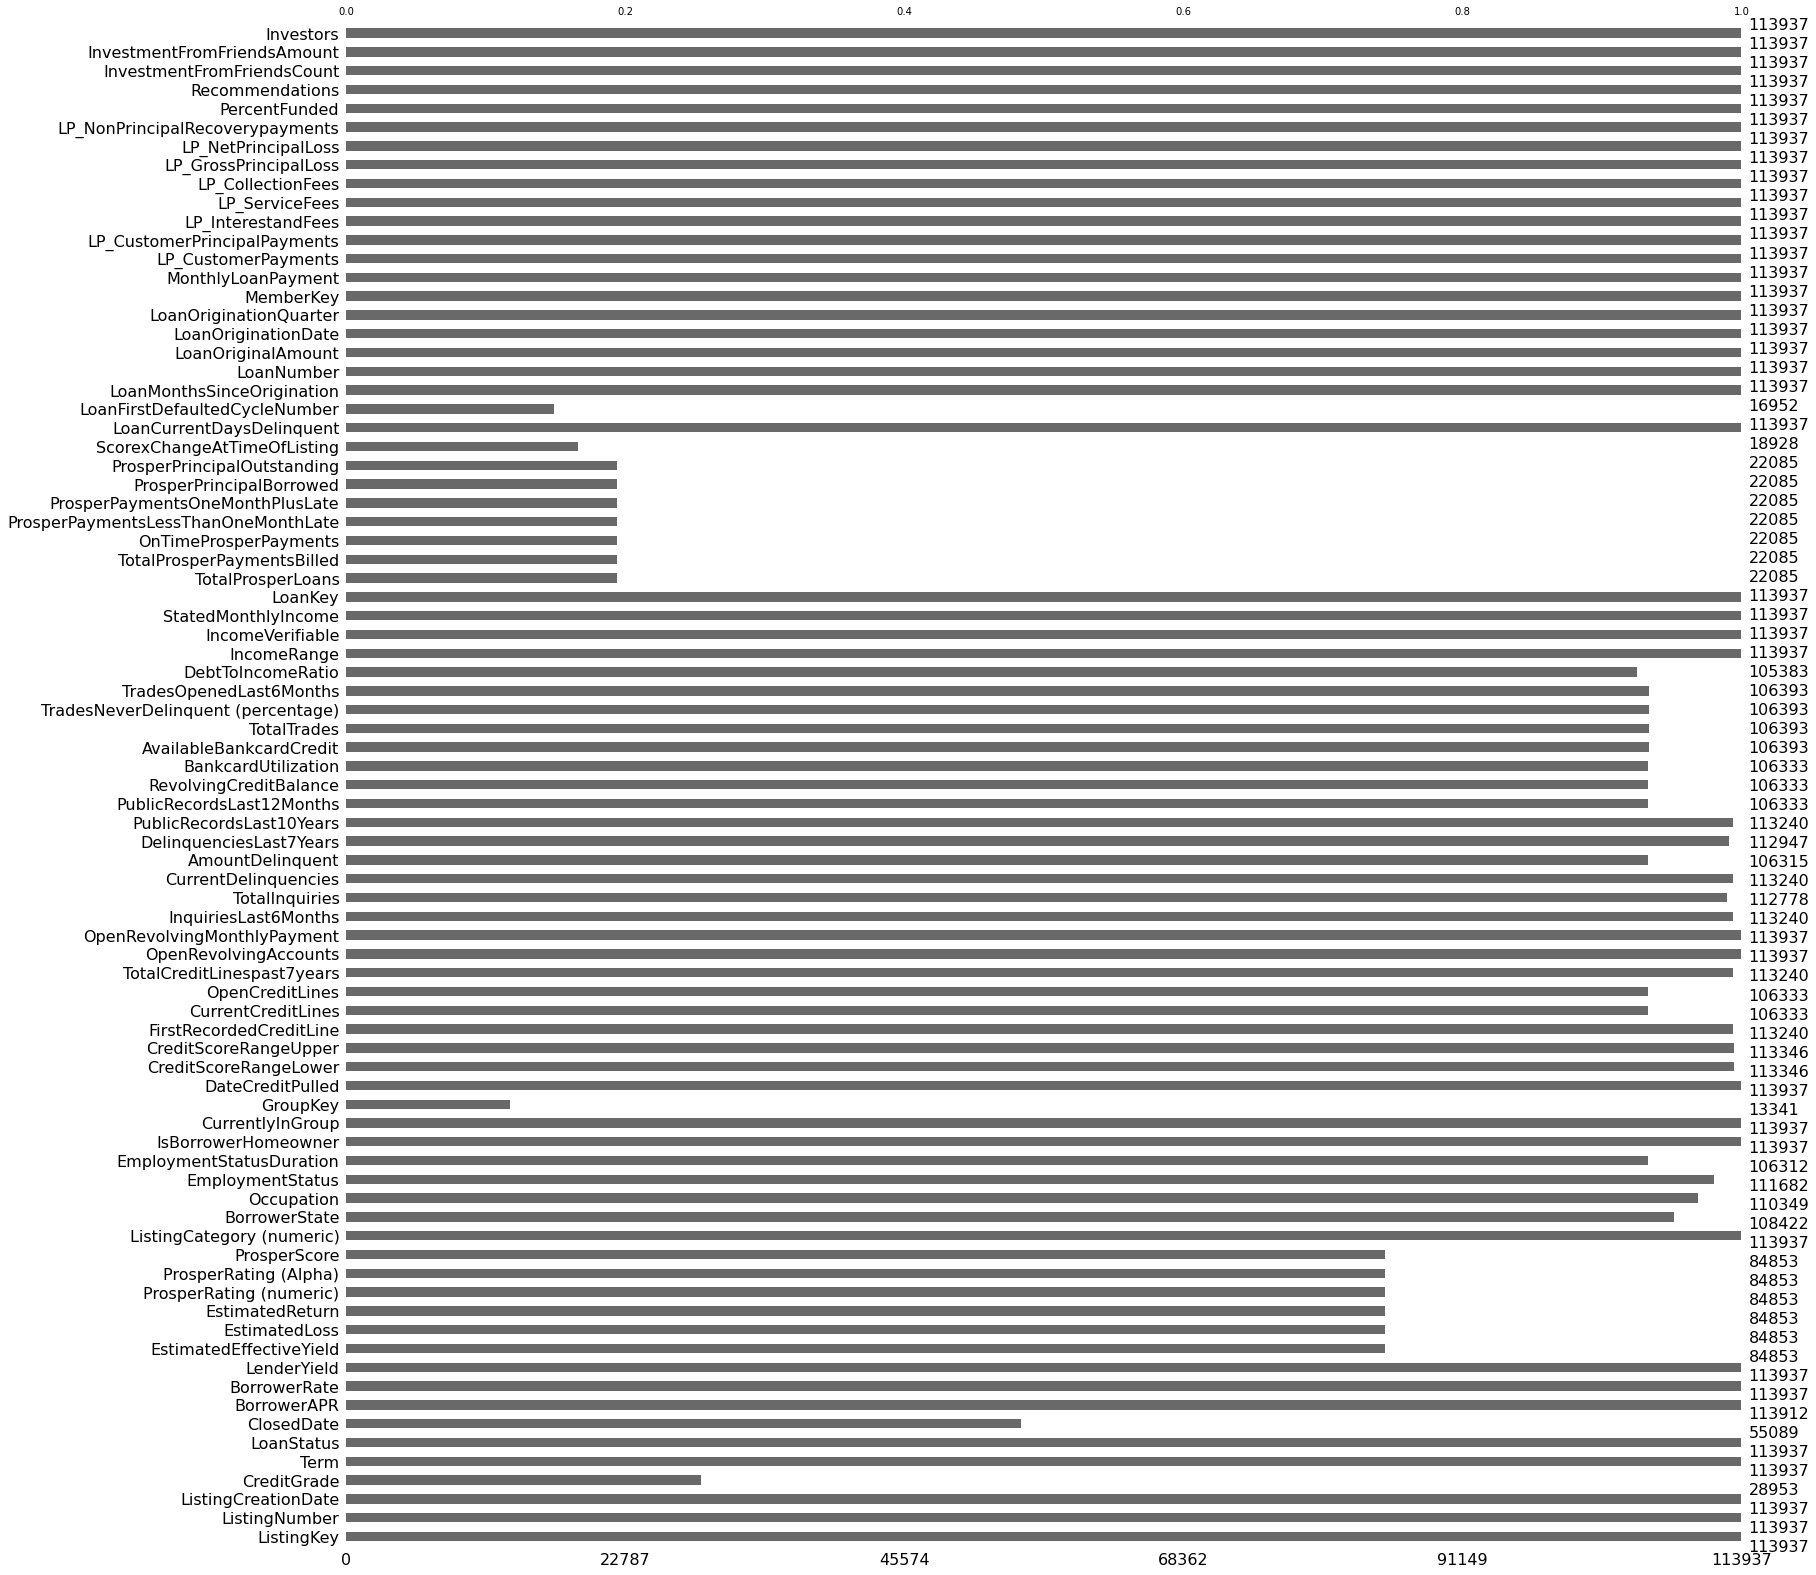

In [3]:
missingno.bar(df)

In [4]:
df['ClosedDate'].isnull().sum()

58848

In [5]:
cols_with_alot_of_nulls=[col for col in df.columns if df[col].isnull().sum() >=58848 ]
cols_with_alot_of_nulls

['CreditGrade',
 'ClosedDate',
 'GroupKey',
 'TotalProsperLoans',
 'TotalProsperPaymentsBilled',
 'OnTimeProsperPayments',
 'ProsperPaymentsLessThanOneMonthLate',
 'ProsperPaymentsOneMonthPlusLate',
 'ProsperPrincipalBorrowed',
 'ProsperPrincipalOutstanding',
 'ScorexChangeAtTimeOfListing',
 'LoanFirstDefaultedCycleNumber']

Removing cols with alot of nulls 

In [6]:
df.drop(columns=cols_with_alot_of_nulls,inplace=True)

<AxesSubplot:>

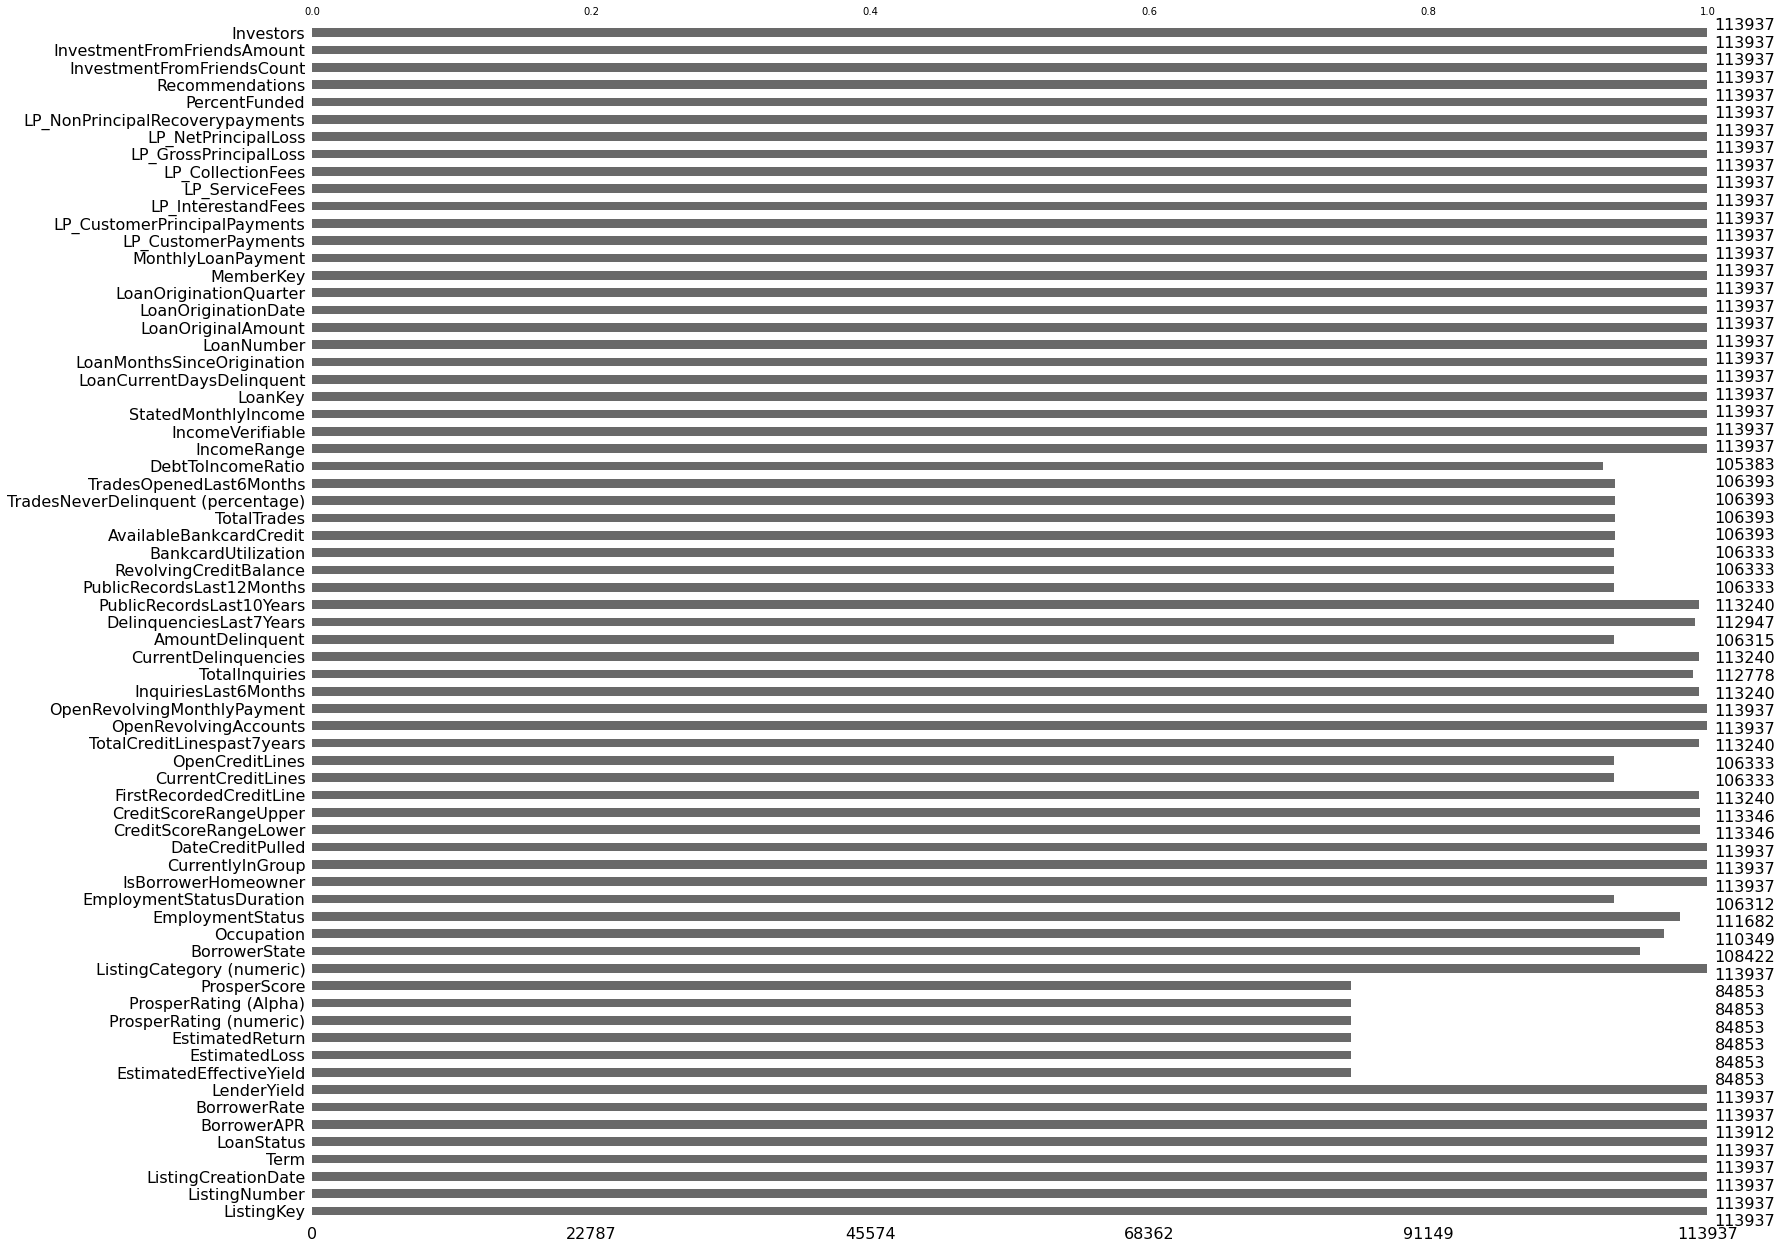

In [7]:
missingno.bar(df)

In [8]:
#df.info()

In [9]:
# cols_to_remove_null_rows_from=[col for col in df.columns if df[col].isnull().sum() >0 ]
# cols_to_remove_null_rows_from

Removing rows with nulls

In [10]:
df.dropna(inplace=True)

<AxesSubplot:>

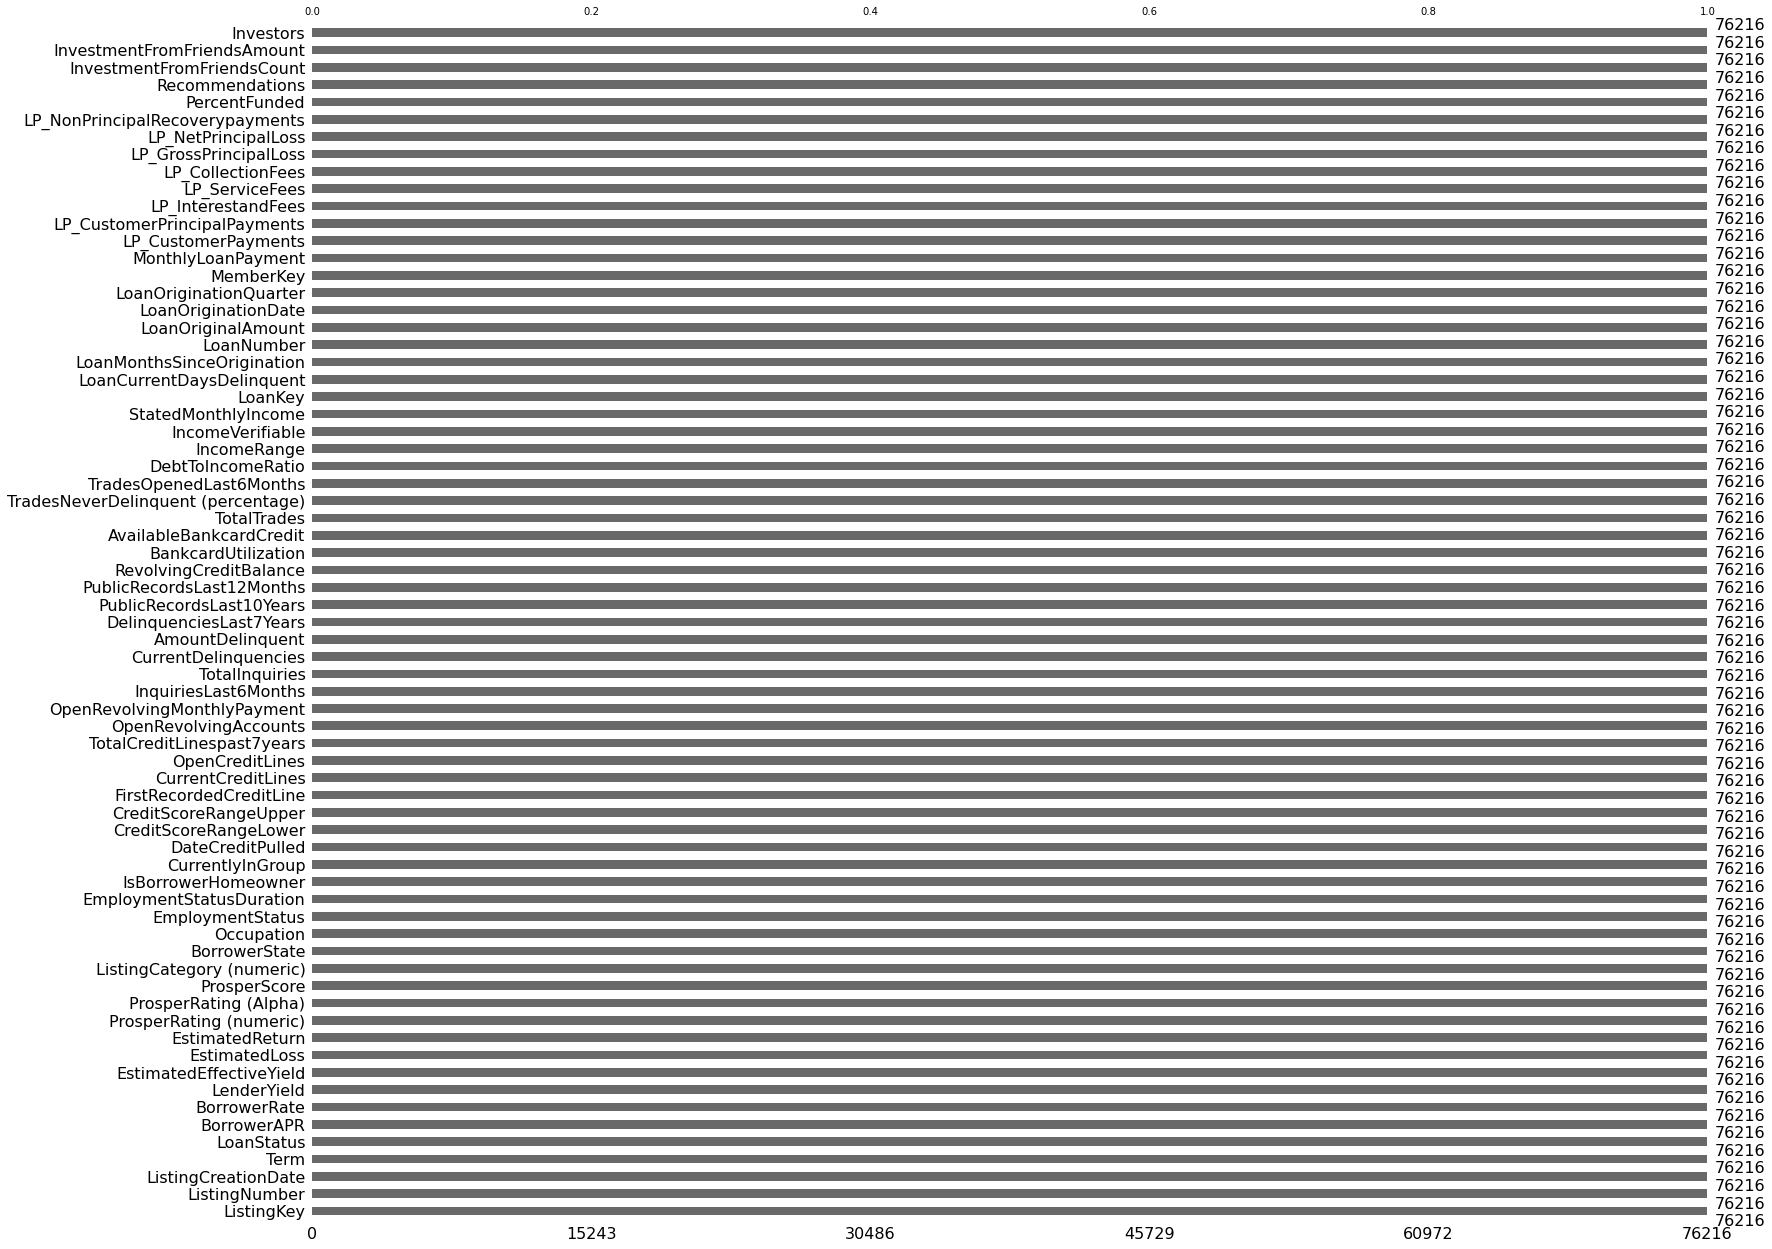

In [11]:
missingno.bar(df)

Feature Selection
---

Handle categorical

In [12]:
df.drop(columns=['ListingKey',
 'ListingCreationDate','FirstRecordedCreditLine','LoanKey','LoanOriginationDate','LoanOriginationQuarter','MemberKey',
                'DateCreditPulled'],inplace=True)

In [13]:
categ_cols=[col for col in df.columns if df[col].dtype in ['object'] ]
categ_cols

['LoanStatus',
 'ProsperRating (Alpha)',
 'BorrowerState',
 'Occupation',
 'EmploymentStatus',
 'IncomeRange']

In [14]:
df['EmploymentStatus'].unique()

array(['Employed', 'Other', 'Full-time', 'Part-time', 'Retired',
       'Self-employed', 'Not employed'], dtype=object)

In [15]:
lb= LabelEncoder()

In [16]:
df['IncomeRange']=lb.fit_transform(df['IncomeRange'])
df['Occupation']=lb.fit_transform(df['Occupation'])
df['BorrowerState']=lb.fit_transform(df['BorrowerState'])
df['ProsperRating (Alpha)']=lb.fit_transform(df['ProsperRating (Alpha)'])

In [17]:
Employment_mapping = {
           'Employed':8,
           'Other': 3,
           'Full-time': 8,
            'Self-employed': 6,
            'Retired': 2,
            'Part-time': 4,
            'Not employed':2 }           

df['EmploymentStatus'] = df['EmploymentStatus'].map(Employment_mapping)

In [18]:
df['EmploymentStatus'].unique()

array([8, 3, 4, 2, 6], dtype=int64)

In [19]:
#df['ProsperRating (Alpha)'].unique()

Map target

In [20]:
df['LoanStatus'] = df['LoanStatus'].apply(lambda x: x.split(" ")[0]).astype(str) 

In [21]:
Status_mapping = {
           'Current': 1,
           'Completed': 1,
           'Past': 0,
            'Defaulted': 0,
            'Chargedoff': 0,
            'FinalPaymentInProgress': 0}

df['LoanStatus'] = df['LoanStatus'].map(Status_mapping)

In [22]:
y=df['LoanStatus']

In [23]:
X=df.drop(columns='LoanStatus')

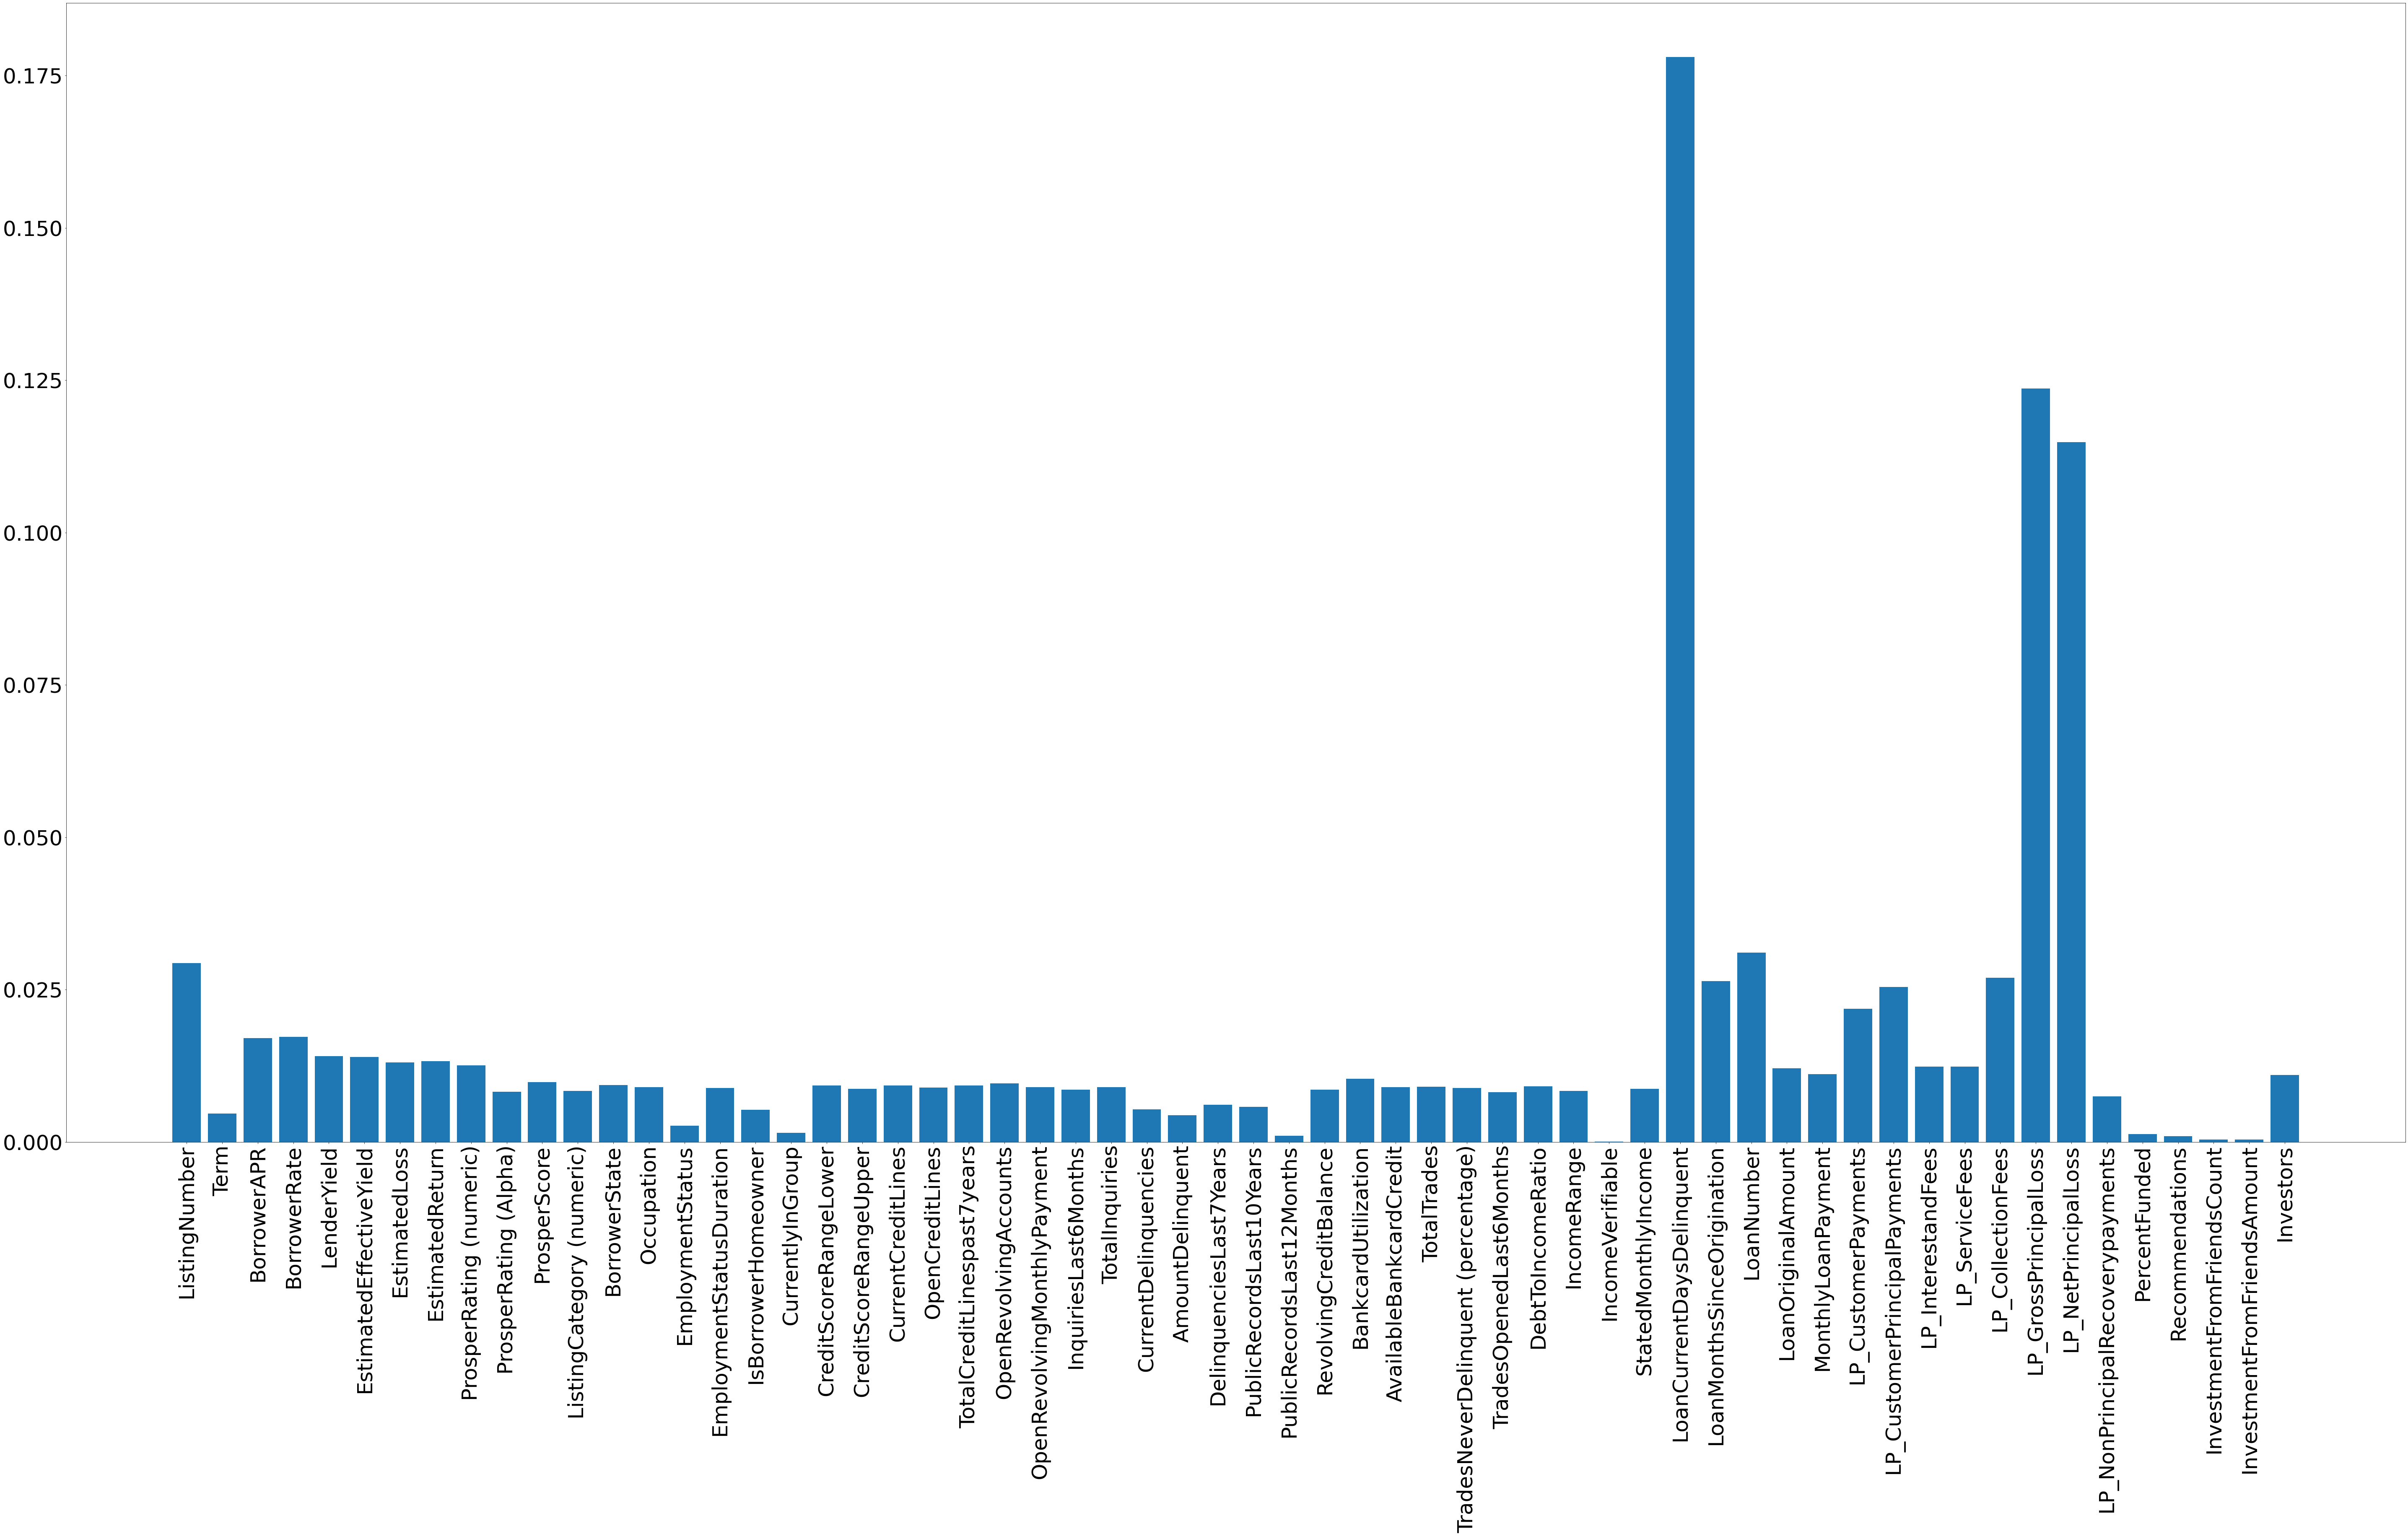

In [24]:
clf = ExtraTreesClassifier(n_estimators=50,criterion ='entropy', max_features = 2,random_state=0)
clf.fit(X, y)
feat_importance = clf.feature_importances_ 
plt.figure(figsize = [100, 50])
plt.bar(X.columns,feat_importance)
plt.xticks(fontsize=50, rotation=90)
plt.yticks(fontsize=50)
plt.show() 

In [25]:
X_feats=X.drop(columns=['PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount','IncomeVerifiable','PublicRecordsLast12Months',
                        'CurrentlyInGroup'])

Scale
---

In [26]:
scale=MinMaxScaler()
X_scaled=scale.fit_transform(X_feats)

Split
---

In [27]:
X_train,X_test,y_train,y_test= train_test_split(X_scaled , y ,test_size=0.3,stratify=y,random_state=42 )

Model
---

In [28]:
rf=RandomForestClassifier(n_estimators=50,criterion="entropy",max_depth=6,max_samples=0.8,random_state=42)
model=rf.fit(X_train,y_train)

Hyper Parameter Tunning

In [ ]:
best_param={'n_estimators' : np.arange(100,500,50),
             'max_depth' : np.arange(3,8,1),
            'max_samples' : [0.7,0.8,0.9]
           }
search_param= RandomizedSearchCV(estimator=rf,param_distributions=best_param,n_iter=20,n_jobs=4
                                , cv=5,verbose=6,scoring='accuracy')
search_param.fit(X_train,y_train)

In [31]:
best_after_tunning=search_param.best_params_
best_rf_model=search_param.best_estimator_
new_model=best_rf_model.fit(X_train,y_train)

In [32]:
predictions = new_model.predict(X_test)

In [33]:
print(accuracy_score(predictions,y_test))

0.9975945768642029


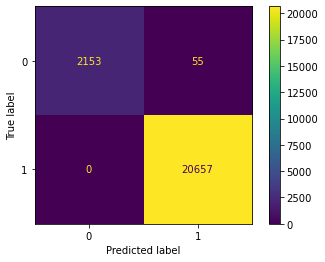

In [34]:
cm=confusion_matrix(y_test,predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [35]:
print(best_rf_model.score(X_test,y_test))
print(best_rf_model.score(X_train,y_train))

0.9975945768642029
0.9975258195722667
